### Based on 
- http://localhost:8187/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/statements/3.1-categorical-unit-neurometric-relates-to-psychometric.ipynb

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
save_figs = True

In [81]:
import os
# set to be lower priority
#os.nice(1)

In [82]:
interpolations = [
        "AE",
        "AF",
        "AG",
        "AH",
        "BE",
        "BF",
        "BG",
        "BH",
        "CE",
        "CF",
        "CG",
        "CH",
        "DE",
        "DF",
        "DG",
        "DH",
    ]

In [5]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed
from datetime import datetime
from joblib import Parallel, delayed
from functools import reduce
from sklearn.decomposition import PCA
from functools import reduce


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [6]:
import seaborn as sns
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic
import scipy.stats
from cdcp.spiketrain_analysis.neurometric import (
    get_interp_points_dists_from_similarity_matrix,
)

In [7]:
%matplotlib inline

In [8]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [9]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [10]:
identifiers = ['nm_by_interpolation_16_25', 'spike_count']

In [11]:
n_interp_bins = 16

In [12]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    
    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print(bird, 'nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)
unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:   0%|          | 0/10 [00:00<?, ?it/s]

B1597 nrows per [6750, 6750]
B1188 nrows per [510, 510]
B1595 nrows per [242, 242]
B1276 nrows per [46, 46]
B1426 nrows per [93, 93]
B1432 nrows per [2157, 2157]
B1170 nrows per [1281, 1281]
B1244 nrows per [141, 141]
B1593 nrows per [7714, 7714]
B1248 nrows per [8698, 8698]


In [13]:
# merge with categorical units
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')
categorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == True]
unit_statistics_df_cat = pd.merge(unit_statistics_df, categorical_units_df, on = ['bird', 'unit'])
# subset categorical units
#unit_statistics_df_cat = unit_statistics_df_cat[unit_statistics_df_cat.categorical_unit == True]
unit_statistics_df = unit_statistics_df_cat
print(len(unit_statistics_df))

### merge with unit types
unit_type_df = pd.read_pickle(DATA_DIR / "unit_classes_01_23_22.pickle")
#unit_type_df = unit_type_df[["nuclei","AP","ML","DV","amplitude","template_amplitude","sr","fw","hw","bird","unit"]]
unit_statistics_df_ut = pd.merge(unit_statistics_df, unit_type_df, on = ['bird', 'unit'])
unit_statistics_df = unit_statistics_df_ut
print(len(unit_statistics_df))

6754
6754


### Melt matrix into 1 row per interpolation

In [14]:
interped_columns = [i  for i in unit_statistics_df.columns if i.split('_')[-1]  in interpolations]
interped_columns_unique = np.unique(['_'.join(i.split('_')[:-1]) for i in interped_columns])

In [15]:
stat_dfs = []
for col in tqdm(interped_columns_unique):
    columns_to_subset = [
        "{}_{}".format(col, i)
        for i in interpolations
        if "{}_{}".format(col, i) in unit_statistics_df.columns
    ]
    columns_to_subset += ["bird", "unit"]
    stat_df = unit_statistics_df[columns_to_subset].melt(id_vars=["bird", "unit"])
    stat_df.columns = ["bird", "unit", "interp", col]
    stat_df["interp"] = [i[-2:] for i in stat_df.interp.values]
    stat_dfs.append(stat_df)

  0%|          | 0/34 [00:00<?, ?it/s]

In [16]:
stat_df = reduce(lambda x, y: pd.merge(x, y, on = ['bird', 'unit', 'interp']), stat_dfs)

In [17]:
stat_df = pd.merge(stat_df, unit_statistics_df_cat[
    [
        "bird",
        "unit",
        "n_trials",
        "n_cued_trials",
        "n_incorrect_trials",
        "n_correct_trials",
        "n_reward_trials",
        "n_passive_trials",
        "n_active_trials",
        "n_spikes",
        "categorical_unit",
        "categoricality",
        
    ]
], on = ['bird', 'unit'])

for interped_column in tqdm(interped_columns_unique):
    prop_nan = np.array(
        [
            np.mean(np.isnan(i)) if type(i) == np.ndarray else 1
            for i in tqdm(stat_df[interped_column].values, leave=False, desc=interped_column)
        ]
    )
    stat_df["{}_prop_nan".format(interped_column)] = prop_nan

  0%|          | 0/34 [00:00<?, ?it/s]

ips:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_inflection_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_inflection_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_inflection_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_inflection_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_max_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_max_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_max_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_max_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_min_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_min_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_min_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_min_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_r2_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_r2_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_r2_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_r2_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_range_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_range_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_range_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_range_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_scaled_slope_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_scaled_slope_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_scaled_slope_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_scaled_slope_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_slope_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_slope_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_slope_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_slope_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

rv:   0%|          | 0/108064 [00:00<?, ?it/s]

sm_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

sm_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

sm_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

sm_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

In [18]:
stat_df[:4]

,bird,unit,interp,ips,nm_inflection_correlation,nm_inflection_cosine,nm_inflection_euclidean,nm_inflection_manhattan,nm_max_correlation,nm_max_cosine,nm_max_euclidean,nm_max_manhattan,nm_min_correlation,nm_min_cosine,nm_min_euclidean,nm_min_manhattan,nm_r2_correlation,nm_r2_cosine,nm_r2_euclidean,nm_r2_manhattan,nm_range_correlation,nm_range_cosine,nm_range_euclidean,nm_range_manhattan,nm_scaled_slope_correlation,nm_scaled_slope_cosine,nm_scaled_slope_euclidean,nm_scaled_slope_manhattan,nm_slope_correlation,nm_slope_cosine,nm_slope_euclidean,nm_slope_manhattan,rv,sm_correlation,sm_cosine,sm_euclidean,sm_manhattan,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,categorical_unit,categoricality,ips_prop_nan,nm_inflection_correlation_prop_nan,nm_inflection_cosine_prop_nan,nm_inflection_euclidean_prop_nan,nm_inflection_manhattan_prop_nan,nm_max_correlation_prop_nan,nm_max_cosine_prop_nan,nm_max_euclidean_prop_nan,nm_max_manhattan_prop_nan,nm_min_correlation_prop_nan,nm_min_cosine_prop_nan,nm_min_euclidean_prop_nan,nm_min_manhattan_prop_nan,nm_r2_correlation_prop_nan,nm_r2_cosine_prop_nan,nm_r2_euclidean_prop_nan,nm_r2_manhattan_prop_nan,nm_range_correlation_prop_nan,nm_range_cosine_prop_nan,nm_range_euclidean_prop_nan,nm_range_manhattan_prop_nan,nm_scaled_slope_correlation_prop_nan,nm_scaled_slope_cosine_prop_nan,nm_scaled_slope_euclidean_prop_nan,nm_scaled_slope_manhattan_prop_nan,nm_slope_correlation_prop_nan,nm_slope_cosine_prop_nan,nm_slope_euclidean_prop_nan,nm_slope_manhattan_prop_nan,rv_prop_nan,sm_correlation_prop_nan,sm_cosine_prop_nan,sm_euclidean_prop_nan,sm_manhattan_prop_nan
0,B1597,9474,AE,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",7.529137,7.12514,7.152187,7.132204,0.628102,0.582507,0.509234,0.501483,0.212181,0.314192,0.449464,0.489202,0.597437,0.822434,0.847986,0.800823,0.415921,0.268315,0.05977,0.012281,138.528892,372.696333,1673.068227,8142.778156,57.617025,100.0,100.0,100.0,"[[0.007944877, 0.012419521, 0.016634403, 0.019...","[[1.0, 0.960486, 0.9149142, 0.9587056, 0.95678...","[[1.0, 0.9633575, 0.9301829, 0.9659082, 0.9627...","[[1.0, 0.9145882, 0.90759414, 0.86016595, 0.88...","[[1.0, 0.9858349, 0.9847991, 0.97092766, 0.979...",5612,9,0,0,0,5600,12,2358,True,0.109401,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0
1,B1597,9474,AF,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",7.029179,7.060066,13.0,8.524363,0.490924,0.493951,0.531064,0.501791,0.461844,0.46966,0.480647,0.495942,0.543072,0.552026,0.848617,0.729715,0.02908,0.024292,0.050417,0.005849,3438.7674,4115.76963,56.209475,792.884808,100.0,99.97865,2.833932,4.637577,"[[0.016027803, 0.024336038, 0.031571742, 0.035...","[[1.0, 0.9600967, 0.95765334, 0.9563544, 0.969...","[[1.0, 0.96551675, 0.9567401, 0.96169275, 0.96...","[[1.0, 0.88105357, 0.885755, 0.70282775, 0.911...","[[1.0, 0.9632765, 0.97379357, 0.91801924, 0.98...",5612,9,0,0,0,5600,12,2358,True,0.109401,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0
2,B1597,9474,AG,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",8.204379,8.609525,7.551757,7.541294,0.518823,0.514424,0.515437,0.503097,0.497939,0.498819,0.49274,0.497738,0.362538,0.378482,0.553078,0.333736,0.020884,0.015605,0.022697,0.005359,168.034211,221.892153,4400.962433,18661.666382,3.509229,3.462694,99.890707,100.0,"[[0.025025528, 0.033703506, 0.03998994, 0.0414...","[[1.0, 0.8948454, 0.89415073, 0.5736817, 0.961...","[[1.0, 0.9090164, 0.9004372, 0.6424036, 0.9646...","[[1.0, 0.8216941, 0.7911576, 0.73795325, 0.786...","[[1.0, 0.9635847, 0.95689726, 0.92169976, 0.94...",5612,9,0,0,0,5600,12,2358,True,0.109401,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0
3,B1597,9474,AH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5612,9,0,0,0,5600,12,2358,True,0.109401,1.0,1,1,1,1,1,1,1,1,1,1,

#### unit categoricality from similarity matrix

In [19]:
def z_score(x):
    return (x - np.mean(x)) / np.std(x)

In [20]:
import copy
def get_categoricality(sm, remove_identity=True, norm=True):
    if type(sm) is not np.ndarray:
        return np.nan
    sm = copy.deepcopy(sm)
    cat = int(sm.shape[0]/2)
    
    if norm:
        sm_tril = sm[np.tril_indices(len(sm), k=-1)]
        sm_min = np.nanmin(sm_tril)
        sm_max = np.nanmax(sm_tril)
        sm = (sm-sm_min) / (sm_max - sm_min)
    
    A = sm[:cat, :cat]
    B = sm[cat:, :cat]
    C = sm[cat:, cat:]
    D = sm[:cat, cat:]
    if remove_identity:
        A = A[np.tril_indices(len(A), k=-1)]
        C = C[np.tril_indices(len(C), k=-1)]
    A_mean = np.nanmean(A)
    B_mean = np.nanmean(B)
    C_mean = np.nanmean(C)
    D_mean = np.nanmean(D)
    if np.any(np.isnan([A_mean, B_mean, C_mean, D_mean])):
        return np.nan
    #return np.mean([A_mean,C_mean]) / (np.mean([A_mean,C_mean, B_mean,D_mean]))
    return (np.mean([A_mean,C_mean]) - np.mean([B_mean,D_mean]))

In [21]:
len(stat_df)

108064

In [22]:
metric = "cosine"

In [23]:
interp_categoricality = [
    get_categoricality(row["sm_{}".format(metric)])
    for idx, row in tqdm(stat_df.iterrows(), total=len(stat_df))
]
stat_df["interp_categoricality"] = interp_categoricality

  0%|          | 0/108064 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


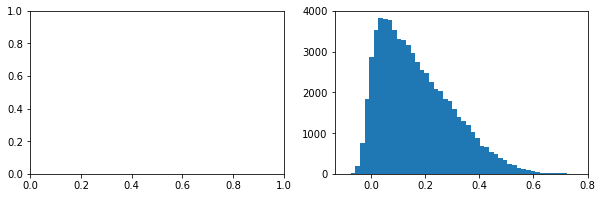

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3))
axs[1].hist(interp_categoricality, bins = 50);

In [25]:
slope_df = stat_df[[
    'bird',
    'unit',
    'interp',
    'nm_r2_cosine',
    'nm_min_cosine',
    'nm_max_cosine',
    'nm_slope_cosine',
    'nm_inflection_cosine',
    'interp_categoricality',
    'sm_cosine_prop_nan'
    
]].rename({
    'nm_r2_cosine':'r2',
    'interp_categoricality':'categoricality',
    'sm_cosine_prop_nan':'sm_pct_nan',
    'nm_slope_cosine':'slope',
    'nm_max_cosine':'_max',
    'nm_min_cosine':'_min',
    'nm_inflection_cosine':'infleciton',
}, axis='columns')
slope_df['range'] = slope_df['_max']  - slope_df['_min'] 
slope_df['scaled_neurometric_slope'] = (slope_df['slope']  * slope_df['range'] ).astype(float)
slope_df["log_scaled_neurometric_slope"] = np.log( 1+
    slope_df.scaled_neurometric_slope.values.astype(float)
)

In [26]:
slope_df[:3]

,bird,unit,interp,r2,_min,_max,slope,infleciton,categoricality,sm_pct_nan,range,scaled_neurometric_slope,log_scaled_neurometric_slope
0,B1597,9474,AE,0.822434,0.314192,0.582507,100.0,7.12514,0.348955,0.0,0.268315,26.831496,3.326168
1,B1597,9474,AF,0.552026,0.46966,0.493951,99.97865,7.060066,0.033765,0.0,0.024292,2.428642,1.232164
2,B1597,9474,AG,0.378482,0.498819,0.514424,3.462694,8.609525,0.002591,0.0,0.015605,0.054036,0.052627


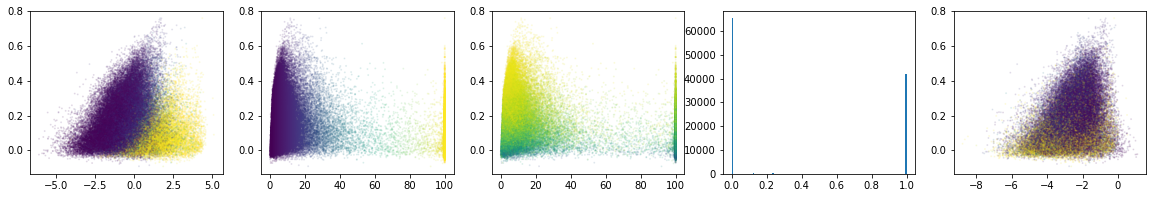

In [27]:
fig, axs = plt.subplots(ncols = 5, figsize = (20,3))
axs[0].scatter(
    np.log(slope_df.scaled_neurometric_slope.values.astype(float)),
    slope_df.categoricality.values,
    s=1,
    alpha=0.1,
    c=slope_df.slope.values,
)
axs[1].scatter(
    slope_df.slope.values.astype(float),
    slope_df.categoricality.values.astype(float),
    s=1,
    alpha=0.1,
    c=slope_df.slope.values,
)
axs[2].scatter(
    slope_df.slope.values.astype(float),
    slope_df.categoricality.values.astype(float),
    s=1,
    alpha=0.1,
    c=slope_df.r2.values,
)

axs[3].hist(slope_df.sm_pct_nan.values, bins = 100);

axs[4].scatter(
    np.log(slope_df.range.values.astype(float)),
    slope_df.categoricality.values.astype(float),
    s=1,
    alpha=0.1,
    c=slope_df.slope.values,
)

In [28]:
# remove bad fits
print(len(slope_df))
slope_df = slope_df[slope_df.sm_pct_nan < 0.01]
print(len(slope_df))
slope_df = slope_df[slope_df.slope.values.astype(float) < 99]
print(len(slope_df))

108064
65273
52383


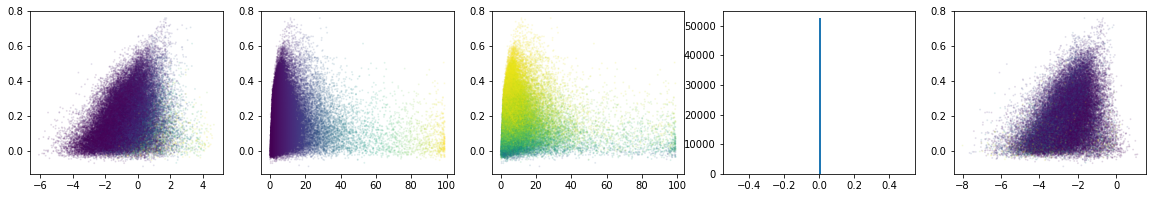

In [29]:
fig, axs = plt.subplots(ncols = 5, figsize = (20,3))
axs[0].scatter(
    np.log(slope_df.scaled_neurometric_slope.values.astype(float)),
    slope_df.categoricality.values,
    s=1,
    alpha=0.1,
    c=slope_df.slope.values,
)
axs[1].scatter(
    slope_df.slope.values.astype(float),
    slope_df.categoricality.values.astype(float),
    s=1,
    alpha=0.1,
    c=slope_df.slope.values,
)
axs[2].scatter(
    slope_df.slope.values.astype(float),
    slope_df.categoricality.values.astype(float),
    s=1,
    alpha=0.1,
    c=slope_df.r2.values,
)

axs[3].hist(slope_df.sm_pct_nan.values, bins = 100);

axs[4].scatter(
    np.log(slope_df.range.values.astype(float)),
    slope_df.categoricality.values.astype(float),
    s=1,
    alpha=0.1,
    c=slope_df.slope.values,
)

<AxesSubplot:xlabel='interp', ylabel='log_scaled_neurometric_slope'>

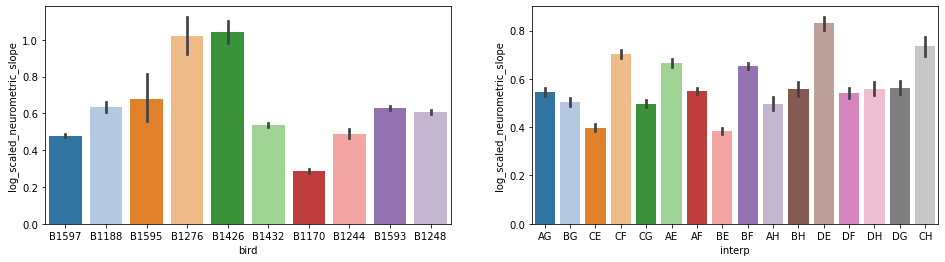

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))
sns.barplot(x='bird', y='log_scaled_neurometric_slope', data=slope_df, palette='tab20', ax = axs[0])
sns.barplot(x='interp', y='log_scaled_neurometric_slope', data=slope_df, palette='tab20', ax = axs[1])

<AxesSubplot:xlabel='interp', ylabel='log_scaled_neurometric_slope'>

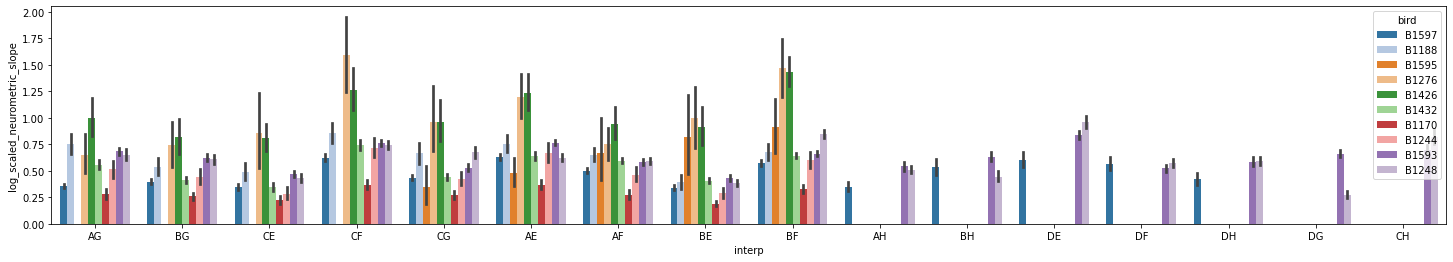

In [31]:
fig, ax = plt.subplots(figsize=(25,4))
sns.barplot(x='interp', y='log_scaled_neurometric_slope', hue="bird", data=slope_df, ax = ax, palette='tab20')

### load behavior

In [32]:
fit_df_interp = pd.read_pickle(DATA_DIR / 'behavior_fit_interp_df.pickle')

In [33]:
fit_df_interp[:3]

,bird,cue,interp,n_points,_min,_max,_inflection,_slope,model,y_interp,r_squared,cue_strength,abs_inflection
0,B1174,NC,AE,14538,0.267878,0.827521,63.716378,53.716164,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.26787826870643316, 0.26787826870643316, 0.2...",0.310321,0.50,0.716378
1,B1174,CL0,AE,6876,0.118257,0.905289,62.506619,23.164028,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.11825659799367827, 0.11825659799367827, 0.1...",0.535872,0.75,0.493381
2,B1174,CN,AE,1606,0.114335,0.872553,62.672477,22.456672,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.11433508106196533, 0.11433508106196533, 0.1...",0.523956,0.50,0.327523


In [34]:
fit_df_interp["scaled_psychometric_slope"] = (
    fit_df_interp._slope * (fit_df_interp._max - fit_df_interp._min)
).values.astype(float)

In [35]:
psychometric_slope_df = fit_df_interp[fit_df_interp.cue == 'NC'][['bird', 'interp', '_slope', 'scaled_psychometric_slope']]

In [36]:
psychometric_slope_df[:3]

,bird,interp,_slope,scaled_psychometric_slope
0,B1174,AE,53.716164,30.061864
6,B1174,BF,30.814271,18.339779
12,B1174,AF,8.242520,6.289188


In [37]:
neurometric_psychometric_slope_df = slope_df.merge(
    psychometric_slope_df, on=["bird", "interp"]
)
neurometric_psychometric_slope_df = neurometric_psychometric_slope_df.rename(
    columns={"_slope": "psychometric_slope", "slope": "neurometric_slope"}
)
neurometric_psychometric_slope_df[:3]

,bird,unit,interp,r2,_min,_max,neurometric_slope,infleciton,categoricality,sm_pct_nan,range,scaled_neurometric_slope,log_scaled_neurometric_slope,psychometric_slope,scaled_psychometric_slope
0,B1597,9474,AG,0.378482,0.498819,0.514424,3.462694,8.609525,0.002591,0.0,0.015605,0.054036,0.052627,12.415965,9.721562
1,B1597,5028,AG,0.808406,0.498564,0.50668,3.055003,13.0,0.070632,0.0,0.008115,0.024792,0.024490,12.415965,9.721562
2,B1597,3411,AG,0.803053,0.197903,0.934619,4.941744,9.990566,0.182785,0.0,0.736717,3.640664,1.534858,12.415965,9.721562


In [38]:
neurometric_psychometric_slope_df["log_scaled_psychometric_slope"] = np.log(1+
    neurometric_psychometric_slope_df.scaled_psychometric_slope
)

In [39]:
len(neurometric_psychometric_slope_df)

41181

### Plot relationship between neurometric and psychometric

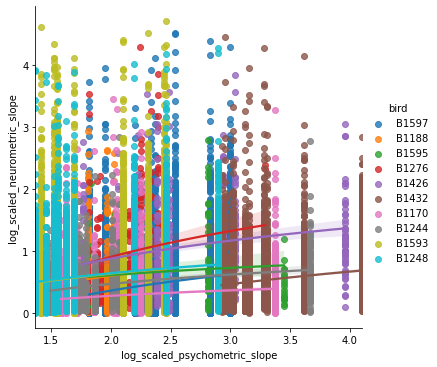

In [40]:
g = sns.lmplot(
    x="log_scaled_psychometric_slope",
    y="log_scaled_neurometric_slope",
    hue="bird",
    data=neurometric_psychometric_slope_df,
    logx=True,
)

In [41]:
def get_descriptive_neurometric_psychometric(
    bird_neurometric_psychometric,
    neurometric_column="neurometric_slope",
    psychometric_column="psychometric_slope",
):
    neurometric_description = (
        bird_neurometric_psychometric[["interp", neurometric_column]]
        .groupby(["interp"])
        .describe()[[neurometric_column]][neurometric_column][["count", "mean", "std"]]
    )
    neurometric_description["sem"] = neurometric_description["std"] / np.sqrt(
        neurometric_description["count"]
    )
    neurometric_description = neurometric_description[["mean", "sem"]]
    neurometric_description.columns = ["neurometric_mean", "neurometric_sem"]

    psychometric_description = (
        bird_neurometric_psychometric[["interp", psychometric_column]]
        .groupby(["interp"])
        .describe()[[psychometric_column]][psychometric_column][["mean"]]
    )
    psychometric_description.columns = ["psychometric_mean"]
    neurometric_psychometric_mean = pd.concat(
        [psychometric_description, neurometric_description], axis=1
    )
    return neurometric_psychometric_mean

def z_score(x):
    return (x-np.mean(x))/np.std(x)

In [42]:
neurometric_psychometric_slope_df[:3]

,bird,unit,interp,r2,_min,_max,neurometric_slope,infleciton,categoricality,sm_pct_nan,range,scaled_neurometric_slope,log_scaled_neurometric_slope,psychometric_slope,scaled_psychometric_slope,log_scaled_psychometric_slope
0,B1597,9474,AG,0.378482,0.498819,0.514424,3.462694,8.609525,0.002591,0.0,0.015605,0.054036,0.052627,12.415965,9.721562,2.372257
1,B1597,5028,AG,0.808406,0.498564,0.50668,3.055003,13.0,0.070632,0.0,0.008115,0.024792,0.024490,12.415965,9.721562,2.372257
2,B1597,3411,AG,0.803053,0.197903,0.934619,4.941744,9.990566,0.182785,0.0,0.736717,3.640664,1.534858,12.415965,9.721562,2.372257


##### Z score scaled neurometric and psychometric by bird

In [43]:
neurometric_psychometric_slope_df_list = []
for bird in neurometric_psychometric_slope_df.bird.unique():
    bird_neurometric_psychometric = neurometric_psychometric_slope_df[
        neurometric_psychometric_slope_df.bird == bird
    ]
    bird_neurometric_psychometric["z_score_log_scaled_neurometric_slope"] = z_score(
        bird_neurometric_psychometric["log_scaled_neurometric_slope"]
    )
    bird_neurometric_psychometric["z_score_log_scaled_psychometric_slope"] = z_score(
        bird_neurometric_psychometric["log_scaled_psychometric_slope"]
    )
    bird_neurometric_psychometric["z_score_scaled_neurometric_slope"] = z_score(
        bird_neurometric_psychometric["scaled_neurometric_slope"]
    )
    bird_neurometric_psychometric["z_score_scaled_psychometric_slope"] = z_score(
        bird_neurometric_psychometric["scaled_psychometric_slope"]
    )
    neurometric_psychometric_slope_df_list.append(bird_neurometric_psychometric)
neurometric_psychometric_slope_df = pd.concat(neurometric_psychometric_slope_df_list)

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy o

### Plot

In [44]:
bird_neurometric_psychometric[:3]

,bird,unit,interp,r2,_min,_max,neurometric_slope,infleciton,categoricality,sm_pct_nan,range,scaled_neurometric_slope,log_scaled_neurometric_slope,psychometric_slope,scaled_psychometric_slope,log_scaled_psychometric_slope,z_score_log_scaled_neurometric_slope,z_score_log_scaled_psychometric_slope,z_score_scaled_neurometric_slope,z_score_scaled_psychometric_slope
35326,B1248,5065,AF,0.608421,0.475441,0.523426,3.394249,13.0,0.011831,0.0,0.047985,0.162874,0.150895,5.729817,4.441389,1.694034,-0.932422,-0.451622,-0.363572,-0.538396
35327,B1248,3789,AF,0.892482,0.476034,0.526282,8.70239,11.550305,0.100857,0.0,0.050248,0.437278,0.362751,5.729817,4.441389,1.694034,-0.511800,-0.451622,-0.273065,-0.538396
35328,B1248,12002,AF,0.96995,0.351642,0.61312,3.960719,5.602624,0.358951,0.0,0.261478,1.035642,0.710811,5.729817,4.441389,1.694034,0.179242,-0.451622,-0.075706,-0.538396


### Regplot for each bird

In [45]:
from cdcp.visualization.utils import get_cat_colors

In [46]:
_, pal, pal_dict = get_cat_colors(neurometric_psychometric_slope_df.bird.unique(), palette="tab20")

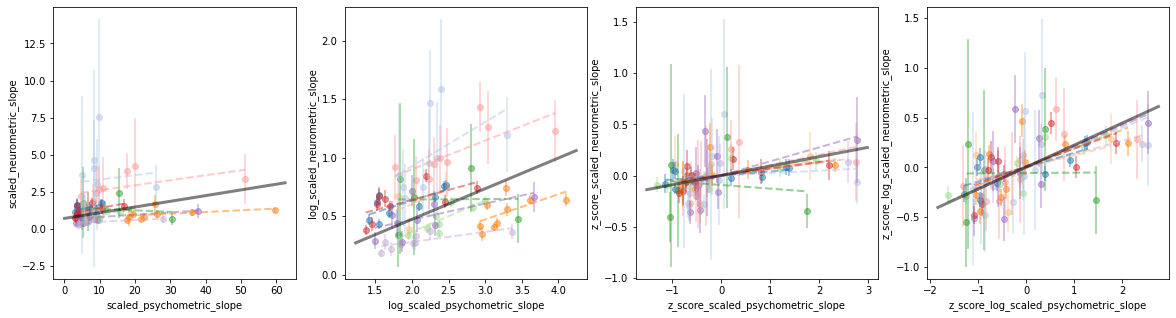

In [47]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
for axi, (neurometric_column, psychometric_column) in enumerate([
    ("scaled_neurometric_slope", "scaled_psychometric_slope"),
    ("log_scaled_neurometric_slope", "log_scaled_psychometric_slope"),
    ("z_score_scaled_neurometric_slope", "z_score_scaled_psychometric_slope"),
    ("z_score_log_scaled_neurometric_slope", "z_score_log_scaled_psychometric_slope")
]):
    ax = axs[axi]
    for bird in neurometric_psychometric_slope_df.bird.unique():
        bird_neurometric_psychometric = neurometric_psychometric_slope_df[
            neurometric_psychometric_slope_df.bird == bird
        ]
        neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
            bird_neurometric_psychometric,
            neurometric_column=neurometric_column,
            psychometric_column=psychometric_column,
        )
        x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
        y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
        y_err = neurometric_psychometric_mean.neurometric_sem.values.astype(float)
        # plot regression
        m, b = np.polyfit(x, y, 1)
        x2 = np.array([np.min(x), np.max(x)])
        ax.plot(x2, m * x2 + b, lw=2, ls="dashed", alpha=0.5, color = pal_dict[bird])
        ax.scatter(x, y,  alpha=0.5,color = pal_dict[bird])
        ax.errorbar(x, y, yerr=y_err * 3, fmt="", ls="none", alpha=0.5, color = pal_dict[bird])
     
    neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
        neurometric_psychometric_slope_df,
        neurometric_column=neurometric_column,
        psychometric_column=psychometric_column,
    )
    x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
    y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
    m, b = np.polyfit(x, y, 1)
    x2 = np.array(ax.get_xlim())
    ax.plot(x2, m * x2 + b, lw=3, ls="solid", alpha=0.5, color = 'k', zorder = 100000)
        
    ax.set_xlabel(psychometric_column)
    ax.set_ylabel(neurometric_column)
    #break
plt.show()

### Regplot for each interpolation

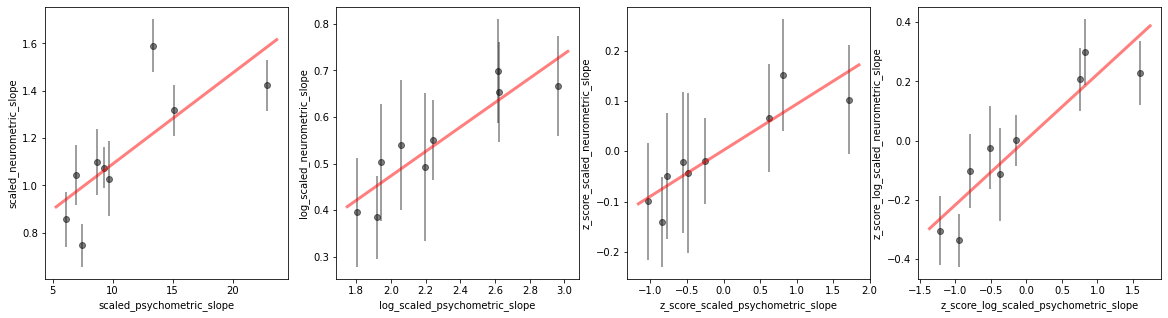

In [48]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
for axi, (neurometric_column, psychometric_column) in enumerate([
    ("scaled_neurometric_slope", "scaled_psychometric_slope"),
    ("log_scaled_neurometric_slope", "log_scaled_psychometric_slope"),
    ("z_score_scaled_neurometric_slope", "z_score_scaled_psychometric_slope"),
    ("z_score_log_scaled_neurometric_slope", "z_score_log_scaled_psychometric_slope")
]):
    ax = axs[axi]
    neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
        neurometric_psychometric_slope_df,
        neurometric_column=neurometric_column,
        psychometric_column=psychometric_column,
    )
    x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
    y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
    
    ax.scatter(x, y,  alpha=0.5,color = 'k')
    ax.errorbar(x, y, yerr=y_err * 3, fmt="", ls="none", alpha=0.5, color = 'k')
    m, b = np.polyfit(x, y, 1)
    x2 = np.array(ax.get_xlim())
    ax.plot(x2, m * x2 + b, lw=3, ls="solid", alpha=0.5, color = 'red', zorder = 100000)
        
    ax.set_xlabel(psychometric_column)
    ax.set_ylabel(neurometric_column)
    #break
plt.show()

In [49]:
from sklearn.linear_model import LinearRegression

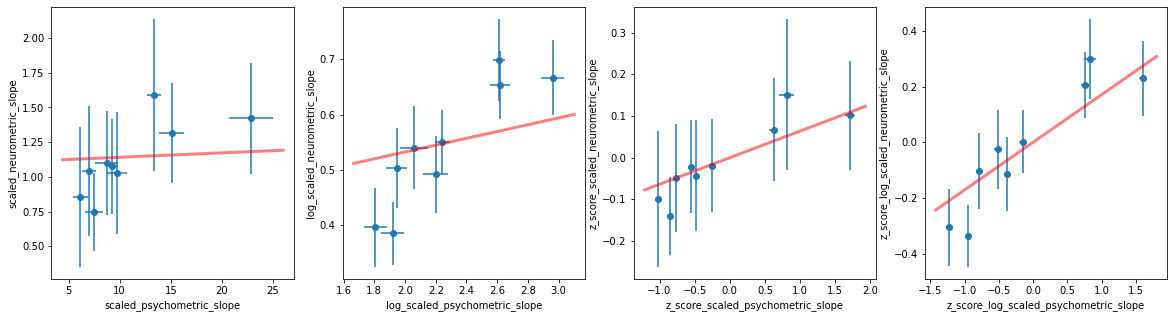

In [50]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
for axi, (neurometric_column, psychometric_column) in enumerate([
    ("scaled_neurometric_slope", "scaled_psychometric_slope"),
    ("log_scaled_neurometric_slope", "log_scaled_psychometric_slope"),
    ("z_score_scaled_neurometric_slope", "z_score_scaled_psychometric_slope"),
    ("z_score_log_scaled_neurometric_slope", "z_score_log_scaled_psychometric_slope")
]):
    ax = axs[axi]
    description_dfs = []
    for factor in [neurometric_column, psychometric_column]:
        description_df = neurometric_psychometric_slope_df[["interp", factor]].groupby(
            "interp"
        ).describe()[factor][["count", "mean", "std"]]
        description_df.columns = ["{}_count".format(factor), "{}_mean".format(factor), "{}_std".format(factor)]
        description_df["{}_sem".format(factor)] = description_df["{}_std".format(factor)] / np.sqrt(description_df["{}_count".format(factor)])
        description_dfs.append(description_df)
    mean_sem_neuro_psycho_df = pd.concat(description_dfs, axis=1)

    x = np.expand_dims(neurometric_psychometric_slope_df[psychometric_column].values.astype(float), -1)
    y = neurometric_psychometric_slope_df[neurometric_column].values.astype(float)
    
    m, b = np.polyfit(x.flatten(), y, 1)
    
    x = mean_sem_neuro_psycho_df["{}_mean".format(psychometric_column)].values
    y = mean_sem_neuro_psycho_df["{}_mean".format(neurometric_column)].values
    x_err = mean_sem_neuro_psycho_df["{}_sem".format(psychometric_column)].values * 3
    y_err = mean_sem_neuro_psycho_df["{}_sem".format(neurometric_column)].values * 3
    ax.scatter(
        x,
        y,
    )
    ax.errorbar(x, y, yerr = y_err*3, xerr = x_err*3, fmt='' , ls='none') 

    x2 = np.array(ax.get_xlim())
    ax.plot(x2, m * x2 + b, lw=3, ls="solid", alpha=0.5, color = 'red', zorder = 100000)

    #plt.plot(x_mod, y_mod)
    ax.set_xlabel(psychometric_column)
    ax.set_ylabel(neurometric_column)
plt.show()

### Create plot

In [51]:
from cdcp.visualization.colors import subject_dict

In [52]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [53]:
from cdcp.experiment_info import subjects

In [54]:
colors20 = ["#0cc0aa", "#2d595a", "#a7cdd8", "#1f3e9e", "#bc74d8", "#871550", "#3693f2", "#6a10a6", "#f3c5fa", "#fe5cde", "#5e3b57", "#6cce61", "#097b35", "#34f50e", "#7d4400", "#f4a95c", "#d11f0b", "#e1d774", "#db6f8a", "#9d7b84"]
subject_dict = {col:i for i, col in zip(colors20, subjects)}


B1597 (0.08360069467686017, 1.4475431206019147e-18)
B1188 (0.07791943293098039, 0.03443313983268076)
B1595 (-0.010780039290199411, 0.9210604165554113)
B1276 (0.02486292497833055, 0.706386494443602)
B1426 (0.10465077488392004, 0.019372614095071294)
B1432 (0.059155319377798145, 2.1323621998690066e-06)
B1170 (0.06188153986968718, 0.001096926232794055)
B1244 (0.13989928896485335, 1.6547980503098502e-05)
B1593 (0.04081072846438523, 4.559808724530063e-06)
B1248 (0.06763170806186145, 2.2204364323983915e-07)


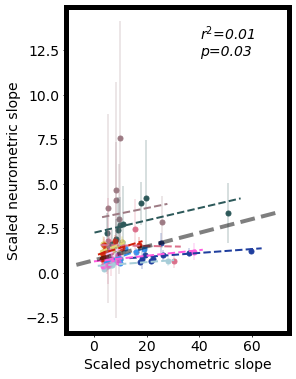

In [55]:
neurometric_column, psychometric_column =  "scaled_neurometric_slope", "scaled_psychometric_slope"
fig, ax = plt.subplots(figsize=(4, 6))
for bird in neurometric_psychometric_slope_df.bird.unique():
    bird_neurometric_psychometric = neurometric_psychometric_slope_df[
        neurometric_psychometric_slope_df.bird == bird
    ]
    
    y = bird_neurometric_psychometric[neurometric_column].values.astype(float)
    x = bird_neurometric_psychometric[psychometric_column].values.astype(float)
    m, b = np.polyfit(x, y, 1)
    print(bird, scipy.stats.pearsonr(x,y))
    neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
        bird_neurometric_psychometric,
        neurometric_column=neurometric_column,
        psychometric_column=psychometric_column,
    )
    x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
    y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
    y_err = neurometric_psychometric_mean.neurometric_sem.values.astype(float)
    # plot regression
   
    x2 = np.array([np.min(x), np.max(x)])
    x2_pad = np.diff(x2)[0] / 10
    x2[0] -= x2_pad
    x2[1] += x2_pad

    ax.plot(x2, m * x2 + b, lw=2, ls="dashed", alpha=1, color=subject_dict[bird])
    ax.scatter(x, y, alpha=1, color=subject_dict[bird], s=25)
    ax.errorbar(
        x, y, yerr=y_err * 3, fmt="", ls="none", alpha=0.25, color=subject_dict[bird]
    )

neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
    neurometric_psychometric_slope_df,
    neurometric_column=neurometric_column,
    psychometric_column=psychometric_column,
)
x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
x2_pad = np.diff(x2)
x2_pad = np.diff(x2)[0] / 20
x2[0] -= x2_pad
x2[1] += x2_pad
ax.plot(x2, m * x2 + b, lw=4, ls="dashed", alpha=0.5, color="k", zorder=100000)



correlation, p_value = scipy.stats.pearsonr(
    neurometric_psychometric_slope_df[neurometric_column].values.astype(float),
    neurometric_psychometric_slope_df[psychometric_column].values.astype(float),
)

ax.text(
    0.6,
    0.85,
    "r$^2$={}\np={:g}".format(round(correlation, 3), float('{:.1g}'.format(p_value))),
    transform=ax.transAxes,
    fontsize=14,
    style='italic',
)

[i.set_linewidth(5) for i in ax.spines.values()]
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Scaled psychometric slope", fontsize=14)
ax.set_ylabel("Scaled neurometric slope", fontsize=14)

ensure_dir(FIGURE_DIR / 'neural-results' / 'neurometric')
if save_figs:
    save_fig(FIGURE_DIR / 'neural-results' / 'neurometric' / 'psychometric-vs-neurometric-unscaled_25ms', save_pdf=True)
plt.show()


B1597 (0.20484150345838917, 8.636220015944252e-105)
B1188 (0.11755018333416634, 0.0013891532190570665)
B1595 (0.08803106996348521, 0.4174812353326783)
B1276 (0.19626443602994192, 0.002677540412925998)
B1426 (0.22779185445686198, 2.696720226976162e-07)
B1432 (0.16770994967049352, 1.133529370636337e-41)
B1170 (0.13110518470671148, 3.935563990603492e-12)
B1244 (0.21595245693224824, 2.159033472800593e-11)
B1593 (0.14610673548586514, 4.1030101607783906e-61)
B1248 (0.17845832844786355, 4.256765450352046e-43)


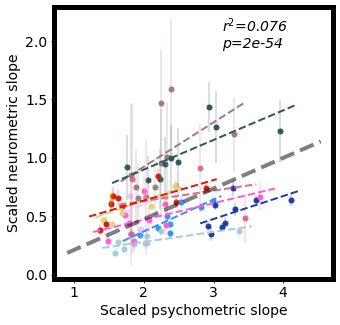

In [56]:
neurometric_column, psychometric_column =  "log_scaled_neurometric_slope", "log_scaled_psychometric_slope"
fig, ax = plt.subplots(figsize=(5,5))
for bird in neurometric_psychometric_slope_df.bird.unique():
    bird_neurometric_psychometric = neurometric_psychometric_slope_df[
        neurometric_psychometric_slope_df.bird == bird
    ]
    
    y = bird_neurometric_psychometric[neurometric_column].values.astype(float)
    x = bird_neurometric_psychometric[psychometric_column].values.astype(float)
    m, b = np.polyfit(x, y, 1)
    print(bird, scipy.stats.pearsonr(x,y))
    neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
        bird_neurometric_psychometric,
        neurometric_column=neurometric_column,
        psychometric_column=psychometric_column,
    )
    x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
    y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
    y_err = neurometric_psychometric_mean.neurometric_sem.values.astype(float)
    # plot regression
   
    x2 = np.array([np.min(x), np.max(x)])
    x2_pad = np.diff(x2)[0] / 10
    x2[0] -= x2_pad
    x2[1] += x2_pad

    ax.plot(x2, m * x2 + b, lw=2, ls="dashed", alpha=1, color=subject_dict[bird])
    ax.scatter(x, y, alpha=1, color=subject_dict[bird], s=25)
    ax.errorbar(
        x, y, yerr=y_err * 3, fmt="", ls="none", alpha=0.25, color=subject_dict[bird]
    )

neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
    neurometric_psychometric_slope_df,
    neurometric_column=neurometric_column,
    psychometric_column=psychometric_column,
)
x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
x2_pad = np.diff(x2)
x2_pad = np.diff(x2)[0] / 20
x2[0] -= x2_pad
x2[1] += x2_pad
ax.plot(x2, m * x2 + b, lw=4, ls="dashed", alpha=0.5, color="k", zorder=100000)



correlation, p_value = scipy.stats.pearsonr(
    neurometric_psychometric_slope_df[neurometric_column].values.astype(float),
    neurometric_psychometric_slope_df[psychometric_column].values.astype(float),
)

ax.text(
    0.6,
    0.85,
    "r$^2$={}\np={:g}".format(round(correlation, 3), float('{:.1g}'.format(p_value))),
    transform=ax.transAxes,
    fontsize=14,
    style='italic',
)

[i.set_linewidth(5) for i in ax.spines.values()]
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Scaled psychometric slope", fontsize=14)
ax.set_ylabel("Scaled neurometric slope", fontsize=14)

ensure_dir(FIGURE_DIR / 'neural-results' / 'neurometric')
if save_figs:
    save_fig(FIGURE_DIR / 'neural-results' / 'neurometric' / 'log_psychometric-vs-neurometric-unscaled-wide_25ms', save_pdf=True)
plt.show()


In [57]:
len(neurometric_psychometric_slope_df[neurometric_column].values.astype(float))

41181

In [58]:
from cdcp.visualization.colors import interp_pal_dict

In [59]:
interp_pal_dict

{'AE': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'AF': (1.0, 0.4980392156862745, 0.054901960784313725),
 'AG': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'BE': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'BF': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'BG': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'CE': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'CF': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'CG': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)}

In [60]:
save_figs = True

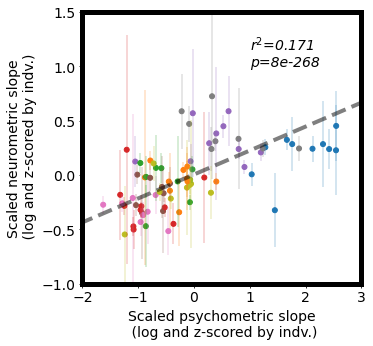

In [61]:
fig, ax = plt.subplots(figsize=(5, 5))
neurometric_column, psychometric_column = (
    "z_score_log_scaled_neurometric_slope",
    "z_score_log_scaled_psychometric_slope",
)
for bird in neurometric_psychometric_slope_df.bird.unique():
    bird_neurometric_psychometric = neurometric_psychometric_slope_df[
        neurometric_psychometric_slope_df.bird == bird
    ]
    neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
        bird_neurometric_psychometric,
        neurometric_column=neurometric_column,
        psychometric_column=psychometric_column,
    )
    x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
    y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
    y_err = neurometric_psychometric_mean.neurometric_sem.values.astype(float)
    # plot regression
    m, b = np.polyfit(x, y, 1)
    x2 = np.array([np.min(x), np.max(x)])
    x2_pad = np.diff(x2)[0] / 10
    x2[0] -= x2_pad
    x2[1] += x2_pad
    c = [interp_pal_dict[i] for i in neurometric_psychometric_mean.index.values]
    # ax.plot(x2, m * x2 + b, lw=2, ls="dashed", alpha=1, color=subject_dict[bird])
    ax.scatter(x, y, alpha=1, c=c, s=25)
    ax.errorbar(x, y, yerr=y_err * 3, fmt="", ls="none", alpha=0.25, c=list(c))

neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
    neurometric_psychometric_slope_df,
    neurometric_column=neurometric_column,
    psychometric_column=psychometric_column,
)
x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
x2_pad = np.diff(x2)
x2_pad = np.diff(x2)[0] / 20
x2[0] -= x2_pad
x2[1] += x2_pad
ax.plot(x2, m * x2 + b, lw=4, ls="dashed", alpha=0.5, color="k", zorder=100000)

ax.set_xlabel(psychometric_column)
ax.set_ylabel(neurometric_column)

# ax.set_yticks([])
# ax.set_xticks([])
[i.set_linewidth(5) for i in ax.spines.values()]
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

correlation, p_value = scipy.stats.pearsonr(
    neurometric_psychometric_slope_df[neurometric_column].values.astype(float),
    neurometric_psychometric_slope_df[psychometric_column].values.astype(float),
)
ax.text(
    0.6,
    0.8,
    "r$^2$={}\np={:g}".format(round(correlation, 3), float("{:.1g}".format(p_value))),
    transform=ax.transAxes,
    fontsize=14,
    style="italic",
)

ax.set_xlim([-2, 3])
ax.set_ylim([-1, 1.5])

ax.set_xlabel("Scaled psychometric slope\n (log and z-scored by indv.)", fontsize=14)
ax.set_ylabel("Scaled neurometric slope\n (log and z-scored by indv.)", fontsize=14)


ensure_dir(FIGURE_DIR / "neural-results" / "neurometric")
if save_figs:
    save_fig(
        FIGURE_DIR
        / "neural-results"
        / "neurometric"
        / "psychometric-vs-neurometric-z-score-wide_25ms",
        save_pdf=True,
    )
plt.show()

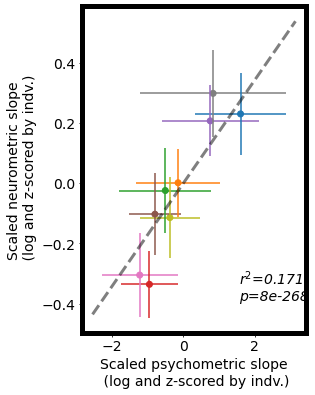

In [62]:
neurometric_column, psychometric_column = (
    "z_score_log_scaled_neurometric_slope",
    "z_score_log_scaled_psychometric_slope",
)
fig, ax = plt.subplots(figsize=(4, 6))
description_dfs = []
for factor in [neurometric_column, psychometric_column]:
    description_df = (
        neurometric_psychometric_slope_df[["interp", factor]]
        .groupby("interp")
        .describe()[factor][["count", "mean", "std"]]
    )
    description_df.columns = [
        "{}_count".format(factor),
        "{}_mean".format(factor),
        "{}_std".format(factor),
    ]
    # adjust to make the count correct for psychometric
    if True:
        for idx, row in mean_sem_neuro_psycho_df.iterrows():
            interp = row.name
            n = len(
                neurometric_psychometric_slope_df[
                    neurometric_psychometric_slope_df.interp == interp
                ].bird.unique()
            )
            description_df.loc[interp, "{}_count".format(psychometric_column)] = n
    description_df["{}_sem".format(factor)] = description_df[
        "{}_std".format(factor)
    ] / np.sqrt(description_df["{}_count".format(factor)])
    description_dfs.append(description_df)
mean_sem_neuro_psycho_df = pd.concat(description_dfs, axis=1)

x = np.expand_dims(
    neurometric_psychometric_slope_df[psychometric_column].values.astype(float), -1
)
y = neurometric_psychometric_slope_df[neurometric_column].values.astype(float)

m, b = np.polyfit(x.flatten(), y, 1)

correlation, p_value = scipy.stats.pearsonr(
    neurometric_psychometric_slope_df[neurometric_column].values.astype(float),
    neurometric_psychometric_slope_df[psychometric_column].values.astype(float),
)
ax.text(
    0.7,
    0.1,
    "r$^2$={}\np={:g}".format(round(correlation, 3), float('{:.1g}'.format(p_value))),
    transform=ax.transAxes,
    fontsize=14,
    style='italic',
)

x = mean_sem_neuro_psycho_df["{}_mean".format(psychometric_column)].values
y = mean_sem_neuro_psycho_df["{}_mean".format(neurometric_column)].values
x_err = mean_sem_neuro_psycho_df["{}_sem".format(psychometric_column)].values * 3
y_err = mean_sem_neuro_psycho_df["{}_sem".format(neurometric_column)].values * 3
ax.scatter(x, y, c=[interp_pal_dict[i] for i in mean_sem_neuro_psycho_df.index.values])
ax.errorbar(
    x,
    y,
    yerr=y_err * 3,
    xerr=x_err * 3,
    fmt="",
    ls="none",
    c=[interp_pal_dict[i] for i in mean_sem_neuro_psycho_df.index.values],
)

x2 = np.array(ax.get_xlim())
ax.plot(x2, m * x2 + b, lw=3, ls="dashed", alpha=0.5, color="k", zorder=100000)

# plt.plot(x_mod, y_mod)
[i.set_linewidth(5) for i in ax.spines.values()]
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)





ax.set_xlabel("Scaled psychometric slope\n (log and z-scored by indv.)", fontsize=14)
ax.set_ylabel("Scaled neurometric slope\n (log and z-scored by indv.)", fontsize=14)

plt.show()


(-0.7, 0.7)

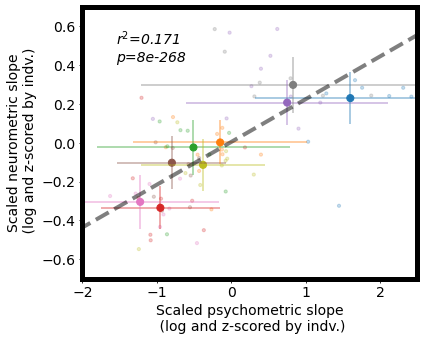

In [63]:
fig, ax = plt.subplots(figsize=(6, 5))
for bird in neurometric_psychometric_slope_df.bird.unique():
    bird_neurometric_psychometric = neurometric_psychometric_slope_df[
        neurometric_psychometric_slope_df.bird == bird
    ]
    neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
        bird_neurometric_psychometric,
        neurometric_column=neurometric_column,
        psychometric_column=psychometric_column,
    )
    x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
    y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
    y_err = neurometric_psychometric_mean.neurometric_sem.values.astype(float)
    # plot regression
    m, b = np.polyfit(x, y, 1)
    x2 = np.array([np.min(x), np.max(x)])
    x2_pad = np.diff(x2)[0] / 10
    x2[0] -= x2_pad
    x2[1] += x2_pad
    c = [interp_pal_dict[i] for i in neurometric_psychometric_mean.index.values]
    # ax.plot(x2, m * x2 + b, lw=2, ls="dashed", alpha=1, color=subject_dict[bird])
    ax.scatter(x, y, alpha=0.25, c=c, s=10)
    #ax.errorbar(
    #    x, y, yerr=y_err * 3, fmt="", ls="none", alpha=0.25, c=[interp_pal_dict[i] for i in neurometric_psychometric_mean.index.values]
    #)

neurometric_psychometric_mean = get_descriptive_neurometric_psychometric(
    neurometric_psychometric_slope_df,
    neurometric_column=neurometric_column,
    psychometric_column=psychometric_column,
)
x = neurometric_psychometric_mean.psychometric_mean.values.astype(float)
y = neurometric_psychometric_mean.neurometric_mean.values.astype(float)
m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
x2_pad = np.diff(x2)
x2_pad = np.diff(x2)[0] / 20
x2[0] -= x2_pad
x2[1] += x2_pad
ax.plot(x2, m * x2 + b, lw=4, ls="dashed", alpha=0.5, color="k", zorder=100000)

ax.set_xlabel(psychometric_column)
ax.set_ylabel(neurometric_column)

# ax.set_yticks([])
# ax.set_xticks([])
[i.set_linewidth(5) for i in ax.spines.values()]
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

correlation, p_value = scipy.stats.pearsonr(
    neurometric_psychometric_slope_df[neurometric_column].values.astype(float),
    neurometric_psychometric_slope_df[psychometric_column].values.astype(float),
)
ax.text(
    0.1,
    0.8,
    "r$^2$={}\np={:g}".format(round(correlation, 3), float('{:.1g}'.format(p_value))),
    transform=ax.transAxes,
    fontsize=14,
    style='italic',
)


ax.set_xlabel("Scaled psychometric slope\n (log and z-scored by indv.)", fontsize=14)
ax.set_ylabel("Scaled neurometric slope\n (log and z-scored by indv.)", fontsize=14)



##### averages

description_dfs = []
for factor in [neurometric_column, psychometric_column]:
    description_df = (
        neurometric_psychometric_slope_df[["interp", factor]]
        .groupby("interp")
        .describe()[factor][["count", "mean", "std"]]
    )
    description_df.columns = [
        "{}_count".format(factor),
        "{}_mean".format(factor),
        "{}_std".format(factor),
    ]
    # adjust to make the count correct for psychometric
    if True:
        for idx, row in mean_sem_neuro_psycho_df.iterrows():
            interp = row.name
            n = len(
                neurometric_psychometric_slope_df[
                    neurometric_psychometric_slope_df.interp == interp
                ].bird.unique()
            )
            description_df.loc[interp, "{}_count".format(psychometric_column)] = n
    description_df["{}_sem".format(factor)] = description_df[
        "{}_std".format(factor)
    ] / np.sqrt(description_df["{}_count".format(factor)])
    description_dfs.append(description_df)
mean_sem_neuro_psycho_df = pd.concat(description_dfs, axis=1)

x = np.expand_dims(
    neurometric_psychometric_slope_df[psychometric_column].values.astype(float), -1
)
y = neurometric_psychometric_slope_df[neurometric_column].values.astype(float)

m, b = np.polyfit(x.flatten(), y, 1)

x = mean_sem_neuro_psycho_df["{}_mean".format(psychometric_column)].values
y = mean_sem_neuro_psycho_df["{}_mean".format(neurometric_column)].values
x_err = mean_sem_neuro_psycho_df["{}_sem".format(psychometric_column)].values * 3
y_err = mean_sem_neuro_psycho_df["{}_sem".format(neurometric_column)].values * 3
ax.scatter(x, y, c=[interp_pal_dict[i] for i in mean_sem_neuro_psycho_df.index.values], s=50)
ax.errorbar(
    x,
    y,
    yerr=y_err * 3,
    xerr=x_err * 3,
    fmt="",
    ls="none",
    alpha = 0.5,
    c=[interp_pal_dict[i] for i in mean_sem_neuro_psycho_df.index.values],
)

ax.set_xlim([-2,2.5])
ax.set_ylim([-0.7, 0.7])

### Does the psychometric slope for an individual bird better predict the neurometric slope than the stimulus alone

In [64]:
neurometric_psychometric_slope_df[['bird', 'unit', 'interp', 'log_scaled_neurometric_slope', 'log_scaled_psychometric_slope']][:3]

,bird,unit,interp,log_scaled_neurometric_slope,log_scaled_psychometric_slope
0,B1597,9474,AG,0.052627,2.372257
1,B1597,5028,AG,0.024490,2.372257
2,B1597,3411,AG,1.534858,2.372257


In [65]:
neurometric_psychometric_slope_df.log_scaled_psychometric_slope

0        2.372257
1        2.372257
2        2.372257
3        2.372257
4        2.372257
           ...   
41176    2.893373
41177    2.893373
41178    2.893373
41179    2.893373
41180    2.893373
Name: log_scaled_psychometric_slope, Length: 41181, dtype: float64

In [66]:
np.sum(neurometric_psychometric_slope_df.log_scaled_psychometric_slope.isnull())

0

In [67]:
np.sum(neurometric_psychometric_slope_df.log_scaled_neurometric_slope.isnull())

0

In [68]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [69]:
model_reduced = smf.ols(
    "log_scaled_neurometric_slope ~ interp + C(bird)",
    data=neurometric_psychometric_slope_df,
)
results_reduced = model_reduced.fit()
print(results_reduced.summary())

                                 OLS Regression Results                                 
Dep. Variable:     log_scaled_neurometric_slope   R-squared:                       0.091
Model:                                      OLS   Adj. R-squared:                  0.090
Method:                           Least Squares   F-statistic:                     241.4
Date:                          Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                                  17:17:51   Log-Likelihood:                -29204.
No. Observations:                         41181   AIC:                         5.844e+04
Df Residuals:                             41163   BIC:                         5.860e+04
Df Model:                                    17                                         
Covariance Type:                      nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [70]:
model_full = smf.ols(
    "log_scaled_neurometric_slope ~ C(interp) + log_scaled_psychometric_slope + C(bird)",
    data=neurometric_psychometric_slope_df,
)
results_full = model_full.fit()
print(results_full.summary())

                                 OLS Regression Results                                 
Dep. Variable:     log_scaled_neurometric_slope   R-squared:                       0.091
Model:                                      OLS   Adj. R-squared:                  0.091
Method:                           Least Squares   F-statistic:                     229.3
Date:                          Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                                  17:17:52   Log-Likelihood:                -29193.
No. Observations:                         41181   AIC:                         5.842e+04
Df Residuals:                             41162   BIC:                         5.859e+04
Df Model:                                    18                                         
Covariance Type:                      nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------

In [87]:
results_full._results.aic - results_reduced._results.aic

-19.907379848977143

In [71]:
from statsmodels.stats.anova import anova_lm

In [72]:
anovaResults = anova_lm(results_reduced, results_full)

In [73]:
anovaResults.__dict__

{'_is_copy': None,
 '_mgr': BlockManager
 Items: Index(['df_resid', 'ssr', 'df_diff', 'ss_diff', 'F', 'Pr(>F)'], dtype='object')
 Axis 1: RangeIndex(start=0, stop=2, step=1)
 NumericBlock: slice(0, 6, 1), 6 x 2, dtype: float64,
 '_item_cache': {'Pr(>F)': 0         NaN
  1    0.000003
  Name: Pr(>F), dtype: float64,
  'F': 0          NaN
  1    21.903098
  Name: F, dtype: float64},
 '_attrs': {},
 '_flags': <Flags(allows_duplicate_labels=True)>}

In [74]:
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,41163.0,9958.683855,0.0,NaN,NaN,NaN
1,41162.0,9953.387464,1.0,5.29639,21.903098,0.000003


In [75]:
0.000003

3e-06